# Multi-Fund Simulation

This notebook simulates dividing capital into multiple independent funds, each operating as a separate single fund. This tests the diversification benefit of splitting capital - whether multiple smaller funds have higher survivorship rates and more stable returns compared to a single large fund.

Key research questions:
- **Survivorship Rate**: Do more funds survive when capital is split?
- **Risk Reduction**: Is portfolio volatility lower with diversification?
- **Return Trade-offs**: What's the cost/benefit of diversification on expected returns?

In [1]:
# Imports
import sys
import os
import importlib
sys.path.append(os.path.abspath('.'))

# Import and reload the module to ensure latest version
import simulation_utils
importlib.reload(simulation_utils)

from simulation_utils import (
    load_and_filter_data,
    run_single_fund_simulation,
    run_multi_fund_simulation,
    plot_simulation_results,
    plot_multi_fund_results,
    print_simulation_summary,
    print_multi_fund_summary
)
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports completed successfully!")

Imports completed successfully!


In [2]:
# Load and prepare data
DATA_PATH = '../dataCollection/all_filtered_markets_full_2024_2025.csv'

print("Loading market data...")
df = load_and_filter_data(DATA_PATH, start_date='2025-01-01')

print(f"Loaded {len(df):,} markets available for simulation")
print(f"Date range: {df['closingDate'].min()} to {df['closingDate'].max()}")
print(f"Markets with complete data: {len(df):,}")

# Show sample of data
print("\nSample of available markets:")
display(df[['market', 'closingDate', 'probability7d', 'probability1d', 'outcome']].head())

Loading market data...
Loaded 3,122 markets available for simulation
Date range: 2025-01-01 12:00:00+00:00 to 2025-12-25 17:30:00+00:00
Markets with complete data: 3,122

Sample of available markets:


,market,closingDate,probability7d,probability1d,outcome
0,Will Trump be Speaker by January 1?,2025-01-01 12:00:00+00:00,0.9960,0.9980,True
1,No Israel x Hamas ceasefire in 2024?,2025-01-01 12:00:00+00:00,0.9150,0.9945,True
2,Will Chris Dobey win the 2024-25 PDC World Cha...,2025-01-03 12:00:00+00:00,0.9735,0.9340,True
3,Will Michael Van Gerwen win the 2024-25 PDC Wo...,2025-01-03 12:00:00+00:00,0.8800,0.7350,True
4,Will Luke Littler win the 2024-25 PDC World Ch...,2025-01-03 12:00:00+00:00,0.6050,0.5850,False


In [12]:
# Base Simulation Parameters
BASE_PARAMS = {
    'starting_capital': 10000,           # Total initial capital (split among funds)
    'start_date': '2025-01-01',          # Simulation start date
    'max_duration_days': 365,            # Maximum simulation duration
    'days_before': 1,                    # Days before resolution to invest
    'min_prob_7d': 0.92,                 # Minimum probability at 7 days
    'min_prob_current': 0.95,            # Minimum probability at investment day
    'ending_factor_start': 0.001,         # Starting ending factor (5% chance)
    'ending_factor_increment': 0.001,    # Daily increment (0.1%)
    'skew_factor': 0.3,                  # Left skew factor for market selection
    'num_simulations': 500                # Number of simulation runs
}

# Test different numbers of funds
FUND_CONFIGURATIONS = [1, 3, 5, 10]  # 1 = single fund baseline, 3/5/10 = multi-fund

print("Multi-Fund Simulation Parameters:")
print("=" * 50)
for param, value in BASE_PARAMS.items():
    print(f"{param}: {value}")

print(f"\nFund configurations to test: {FUND_CONFIGURATIONS}")
print(f"Capital per fund for each configuration:")
for n_funds in FUND_CONFIGURATIONS:
    capital_per_fund = BASE_PARAMS['starting_capital'] / n_funds
    print(f"  {n_funds} fund(s): ${capital_per_fund:,.0f} per fund")

Multi-Fund Simulation Parameters:
starting_capital: 10000
start_date: 2025-01-01
max_duration_days: 365
days_before: 1
min_prob_7d: 0.92
min_prob_current: 0.95
ending_factor_start: 0.001
ending_factor_increment: 0.001
skew_factor: 0.3
num_simulations: 500

Fund configurations to test: [1, 3, 5, 10]
Capital per fund for each configuration:
  1 fund(s): $10,000 per fund
  3 fund(s): $3,333 per fund
  5 fund(s): $2,000 per fund
  10 fund(s): $1,000 per fund


In [13]:
# Run Multi-Fund Simulations
print("Running multi-fund simulations for different configurations...")
print("This will test diversification benefits across fund counts.\n")

all_results = {}
timing_results = {}

for n_funds in FUND_CONFIGURATIONS:
    print(f"Running {BASE_PARAMS['num_simulations']:,} simulations with {n_funds} fund(s)...")
    
    start_time = time.time()
    results = []
    
    # Run simulations with progress bar
    for i in tqdm(range(BASE_PARAMS['num_simulations']), desc=f"{n_funds} fund(s)"):
        if n_funds == 1:
            # Use single fund simulation for baseline
            result = run_single_fund_simulation(
                df=df,
                starting_capital=BASE_PARAMS['starting_capital'],
                start_date=BASE_PARAMS['start_date'],
                max_duration_days=BASE_PARAMS['max_duration_days'],
                days_before=BASE_PARAMS['days_before'],
                min_prob_7d=BASE_PARAMS['min_prob_7d'],
                min_prob_current=BASE_PARAMS['min_prob_current'],
                ending_factor_start=BASE_PARAMS['ending_factor_start'],
                ending_factor_increment=BASE_PARAMS['ending_factor_increment'],
                skew_factor=BASE_PARAMS['skew_factor'],
                target_return=None,
                random_seed=i
            )
            # Convert to multi-fund format for consistency
            result = {
                'portfolio_final_capital': result['final_capital'],
                'portfolio_total_return': result['total_return'],
                'n_funds': 1,
                'surviving_funds': 0 if result['went_bust'] else 1,
                'survivorship_rate': 0.0 if result['went_bust'] else 1.0,
                'bust_rate': 1.0 if result['went_bust'] else 0.0,
                'fund_results': [result],
                'parameters': result['parameters']
            }
        else:
            # Use multi-fund simulation
            result = run_multi_fund_simulation(
                df=df,
                n_funds=n_funds,
                starting_capital=BASE_PARAMS['starting_capital'],
                start_date=BASE_PARAMS['start_date'],
                max_duration_days=BASE_PARAMS['max_duration_days'],
                days_before=BASE_PARAMS['days_before'],
                min_prob_7d=BASE_PARAMS['min_prob_7d'],
                min_prob_current=BASE_PARAMS['min_prob_current'],
                ending_factor_start=BASE_PARAMS['ending_factor_start'],
                ending_factor_increment=BASE_PARAMS['ending_factor_increment'],
                skew_factor=BASE_PARAMS['skew_factor'],
                target_return=None,
                random_seed=i
            )
        
        results.append(result)
    
    elapsed = time.time() - start_time
    all_results[n_funds] = results
    timing_results[n_funds] = elapsed
    
    print(f"Completed {n_funds} fund(s) simulation in {elapsed:.1f} seconds\n")

total_time = sum(timing_results.values())
print(f"All multi-fund simulations completed in {total_time:.1f} seconds!")

Running multi-fund simulations for different configurations...
This will test diversification benefits across fund counts.

Running 500 simulations with 1 fund(s)...


1 fund(s): 100%|██████████| 500/500 [00:41<00:00, 11.98it/s]


Completed 1 fund(s) simulation in 41.8 seconds

Running 500 simulations with 3 fund(s)...


3 fund(s): 100%|██████████| 500/500 [02:25<00:00,  3.43it/s]


Completed 3 fund(s) simulation in 145.8 seconds

Running 500 simulations with 5 fund(s)...


5 fund(s): 100%|██████████| 500/500 [01:19<00:00,  6.28it/s]


Completed 5 fund(s) simulation in 79.6 seconds

Running 500 simulations with 10 fund(s)...


10 fund(s): 100%|██████████| 500/500 [03:51<00:00,  2.16it/s]

Completed 10 fund(s) simulation in 231.8 seconds

All multi-fund simulations completed in 499.0 seconds!


In [14]:
# Results Summary for Each Configuration
for n_funds in FUND_CONFIGURATIONS:
    print("=" * 80)
    print(f"RESULTS FOR {n_funds} FUND(S)")
    print("=" * 80)
    
    if n_funds == 1:
        # Convert single fund results for display
        single_results = [r['fund_results'][0] for r in all_results[n_funds]]
        print_simulation_summary(single_results)
    else:
        print_multi_fund_summary(all_results[n_funds])
    
    print("\n")

RESULTS FOR 1 FUND(S)
SIMULATION SUMMARY
Total Simulations: 500
Went Bust: 34 (6.8%)
Positive Returns: 466 (93.2%)

FINAL CAPITAL STATISTICS:
Mean: $10,575.03
Median: $11,139.03
Std Dev: $2,969.76
Min: $0.00
Max: $15,637.89

RETURN STATISTICS:
Mean: 5.8%
Median: 11.4%
Std Dev: 29.7%
Min: -100.0%
Max: 56.4%

TRADE STATISTICS:
Mean Trades: 13.5
Median Trades: 13.0
Min Trades: 1
Max Trades: 37

RETURN PERCENTILES:
5th percentile: -100.0%
10th percentile: 2.2%
25th percentile: 6.6%
75th percentile: 16.8%
90th percentile: 23.7%
95th percentile: 29.8%


RESULTS FOR 3 FUND(S)
MULTI-FUND SIMULATION SUMMARY
Total Simulations: 500
Funds per Portfolio: 3
Starting Capital per Fund: $3,333
Total Starting Capital: $10,000

PORTFOLIO SURVIVORSHIP:
Total Portfolio Bust Rate: 0.0% (0 portfolios)
Average Surviving Funds: 2.8 / 3
Average Survivorship Rate: 94.1%
Portfolios with All Funds Surviving: 426 (85.2%)

PORTFOLIO PERFORMANCE:
Positive Returns: 426 (85.2%)

PORTFOLIO CAPITAL STATISTICS:
Mean: $10,

In [15]:
# Comparative Analysis Across Fund Configurations
print("DIVERSIFICATION ANALYSIS: COMPARING FUND CONFIGURATIONS")
print("=" * 70)

# Extract key metrics for comparison
comparison_data = {}

for n_funds in FUND_CONFIGURATIONS:
    results = all_results[n_funds]
    
    # Calculate metrics
    portfolio_returns = [r['portfolio_total_return'] for r in results]
    portfolio_capitals = [r['portfolio_final_capital'] for r in results]
    survivorship_rates = [r['survivorship_rate'] for r in results]
    
    # Portfolio-level bust rate (all funds in portfolio go bust)
    total_bust_rate = sum(1 for r in results if r['surviving_funds'] == 0) / len(results)
    
    comparison_data[n_funds] = {
        'avg_return': np.mean(portfolio_returns),
        'return_volatility': np.std(portfolio_returns),
        'median_return': np.median(portfolio_returns),
        'positive_return_rate': sum(1 for r in portfolio_returns if r > 0) / len(portfolio_returns),
        'total_bust_rate': total_bust_rate,
        'avg_survivorship': np.mean(survivorship_rates),
        'avg_final_capital': np.mean(portfolio_capitals),
        'capital_volatility': np.std(portfolio_capitals)
    }

# Display comparison table
print(f"{'Fund Count':<12} {'Avg Return':<12} {'Return Vol':<12} {'Pos Return':<12} {'Bust Rate':<12} {'Avg Survival':<12}")
print("-" * 72)
for n_funds in FUND_CONFIGURATIONS:
    data = comparison_data[n_funds]
    print(f"{n_funds:<12} {data['avg_return']:>10.1%} {data['return_volatility']:>10.1%} {data['positive_return_rate']:>10.1%} {data['total_bust_rate']:>10.1%} {data['avg_survivorship']:>10.1%}")

print(f"\nKey Insights:")
single_fund_data = comparison_data[1]
best_multi_fund = max([n for n in FUND_CONFIGURATIONS if n > 1], key=lambda x: comparison_data[x]['avg_survivorship'])
best_data = comparison_data[best_multi_fund]

print(f"• Best survivorship: {best_multi_fund} funds ({best_data['avg_survivorship']:.1%} vs {single_fund_data['avg_survivorship']:.1%} for single)")
print(f"• Risk reduction: {best_data['return_volatility']:.1%} volatility vs {single_fund_data['return_volatility']:.1%} for single fund")
print(f"• Return trade-off: {best_data['avg_return']:.1%} vs {single_fund_data['avg_return']:.1%} average return")
print(f"• Bust rate improvement: {single_fund_data['total_bust_rate']:.1%} → {best_data['total_bust_rate']:.1%}")

DIVERSIFICATION ANALYSIS: COMPARING FUND CONFIGURATIONS
Fund Count   Avg Return   Return Vol   Pos Return   Bust Rate    Avg Survival
------------------------------------------------------------------------
1                  5.8%      29.7%      93.2%       6.8%      93.2%
3                  6.4%      17.5%      85.2%       0.0%      94.1%
5                  6.3%      13.2%      74.0%       0.0%      93.8%
10                 6.4%       9.0%      81.6%       0.0%      93.8%

Key Insights:
• Best survivorship: 3 funds (94.1% vs 93.2% for single)
• Risk reduction: 17.5% volatility vs 29.7% for single fund
• Return trade-off: 6.4% vs 5.8% average return
• Bust rate improvement: 6.8% → 0.0%


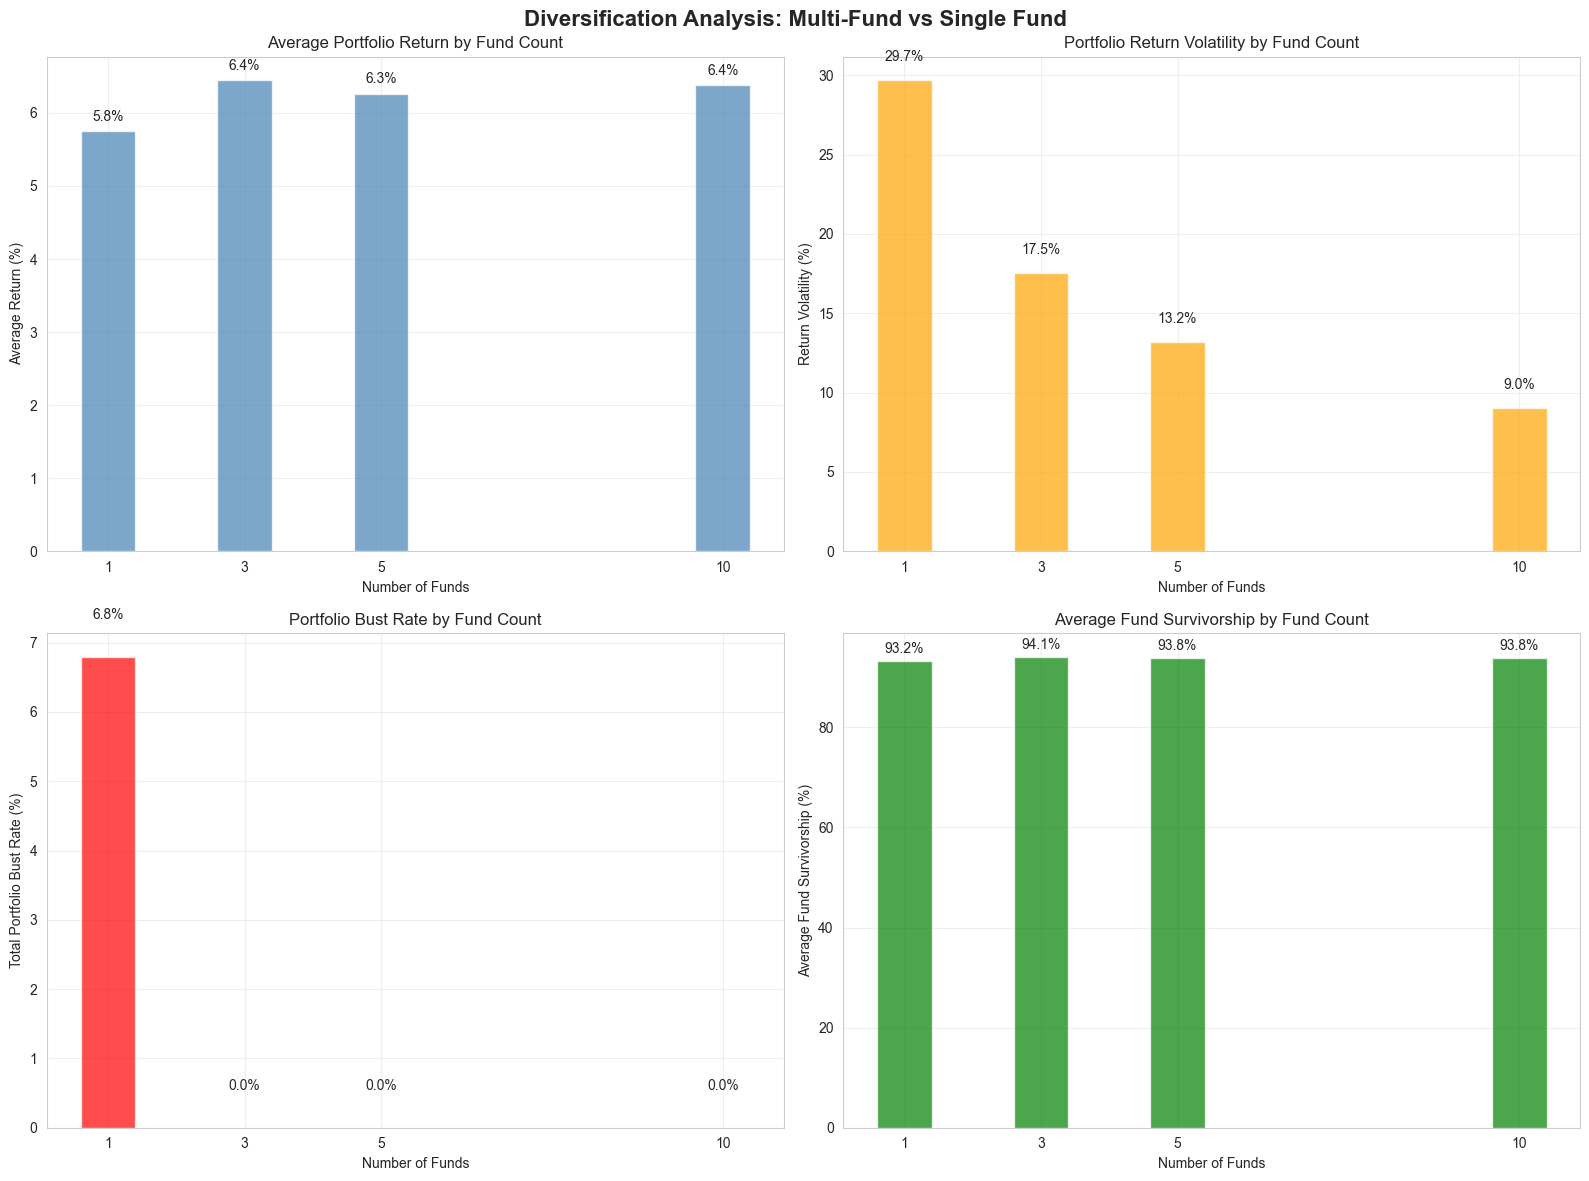

In [16]:
# Visualization: Diversification Benefits
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fund_counts = list(FUND_CONFIGURATIONS)
avg_returns = [comparison_data[n]['avg_return'] * 100 for n in fund_counts]
return_volatilities = [comparison_data[n]['return_volatility'] * 100 for n in fund_counts]
bust_rates = [comparison_data[n]['total_bust_rate'] * 100 for n in fund_counts]
survivorship_rates = [comparison_data[n]['avg_survivorship'] * 100 for n in fund_counts]

# Plot 1: Average Returns by Fund Count
axes[0, 0].bar(fund_counts, avg_returns, alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Number of Funds')
axes[0, 0].set_ylabel('Average Return (%)')
axes[0, 0].set_title('Average Portfolio Return by Fund Count')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(fund_counts)

# Add value labels
for i, v in enumerate(avg_returns):
    axes[0, 0].text(fund_counts[i], v + 0.1, f'{v:.1f}%', ha='center', va='bottom')

# Plot 2: Return Volatility by Fund Count
axes[0, 1].bar(fund_counts, return_volatilities, alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Number of Funds')
axes[0, 1].set_ylabel('Return Volatility (%)')
axes[0, 1].set_title('Portfolio Return Volatility by Fund Count')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(fund_counts)

# Add value labels
for i, v in enumerate(return_volatilities):
    axes[0, 1].text(fund_counts[i], v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Plot 3: Bust Rate by Fund Count
axes[1, 0].bar(fund_counts, bust_rates, alpha=0.7, color='red')
axes[1, 0].set_xlabel('Number of Funds')
axes[1, 0].set_ylabel('Total Portfolio Bust Rate (%)')
axes[1, 0].set_title('Portfolio Bust Rate by Fund Count')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(fund_counts)

# Add value labels
for i, v in enumerate(bust_rates):
    axes[1, 0].text(fund_counts[i], v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Plot 4: Average Survivorship by Fund Count
axes[1, 1].bar(fund_counts, survivorship_rates, alpha=0.7, color='green')
axes[1, 1].set_xlabel('Number of Funds')
axes[1, 1].set_ylabel('Average Fund Survivorship (%)')
axes[1, 1].set_title('Average Fund Survivorship by Fund Count')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(fund_counts)

# Add value labels
for i, v in enumerate(survivorship_rates):
    axes[1, 1].text(fund_counts[i], v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.suptitle('Diversification Analysis: Multi-Fund vs Single Fund', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Detailed Analysis for Best Configuration: 3 Fund(s)


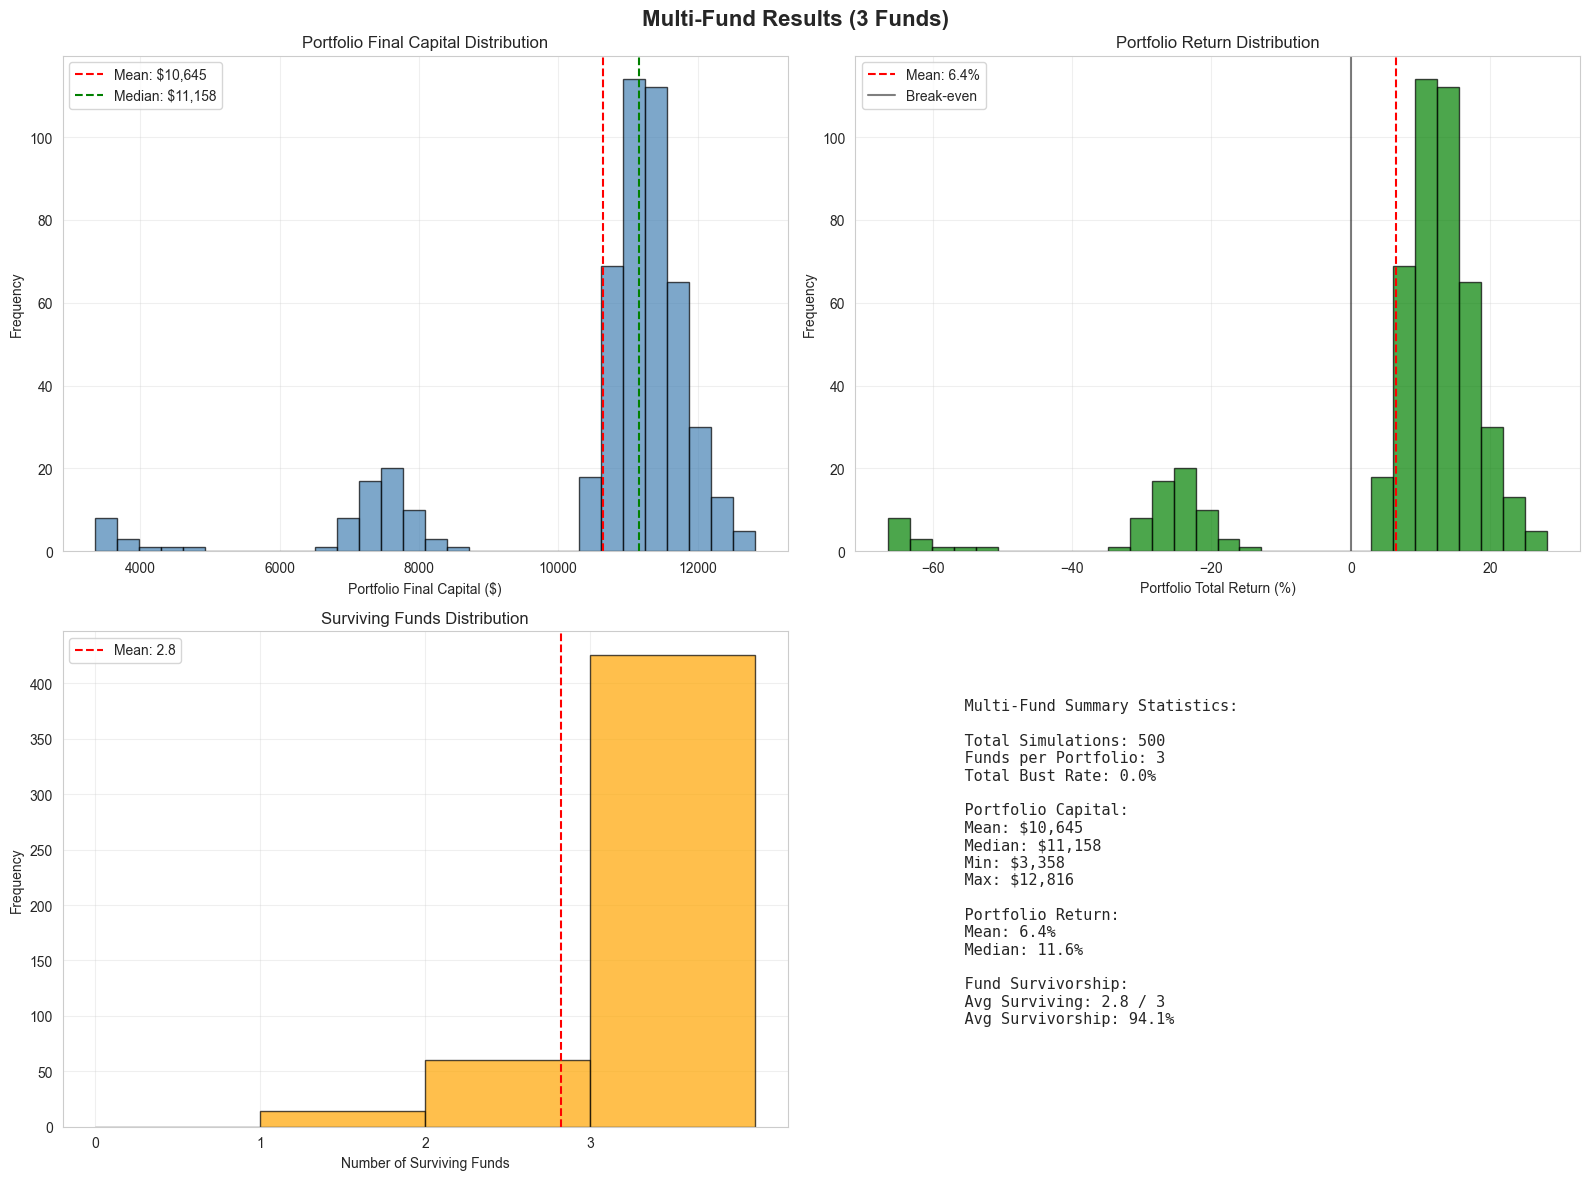

In [17]:
# Detailed Results for Best Performing Configuration
best_config = max(FUND_CONFIGURATIONS, key=lambda x: comparison_data[x]['avg_survivorship'])
print(f"Detailed Analysis for Best Configuration: {best_config} Fund(s)")
print("=" * 60)

if best_config == 1:
    plot_simulation_results([r['fund_results'][0] for r in all_results[best_config]], 
                           title=f"Single Fund Results (Baseline)")
else:
    plot_multi_fund_results(all_results[best_config], 
                           title=f"Multi-Fund Results ({best_config} Funds)")

RISK-RETURN ANALYSIS


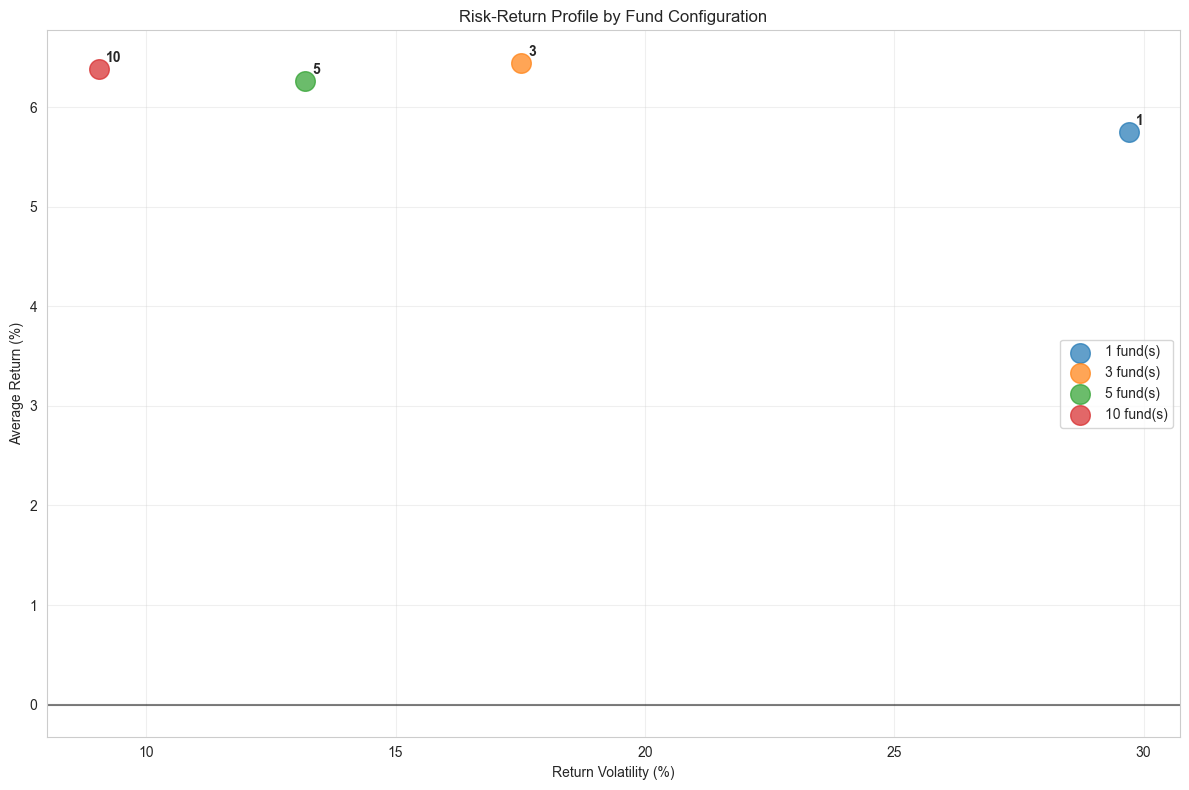


Risk-Adjusted Performance:
Funds    Sharpe Ratio    Return/Risk    
----------------------------------------
1                 0.19          0.19
3                 0.37          0.37
5                 0.48          0.48
10                0.71          0.71


In [18]:
# Risk-Return Analysis
print("RISK-RETURN ANALYSIS")
print("=" * 40)

# Create risk-return scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

for n_funds in FUND_CONFIGURATIONS:
    data = comparison_data[n_funds]
    ax.scatter(data['return_volatility'] * 100, data['avg_return'] * 100, 
              s=200, alpha=0.7, label=f'{n_funds} fund(s)')
    
    # Add annotations
    ax.annotate(f'{n_funds}', 
               (data['return_volatility'] * 100, data['avg_return'] * 100),
               xytext=(5, 5), textcoords='offset points', fontweight='bold')

ax.set_xlabel('Return Volatility (%)')
ax.set_ylabel('Average Return (%)')
ax.set_title('Risk-Return Profile by Fund Configuration')
ax.legend()
ax.grid(True, alpha=0.3)

# Add efficient frontier reference line
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Break-even')

plt.tight_layout()
plt.show()

# Print risk-adjusted metrics
print(f"\nRisk-Adjusted Performance:")
print(f"{'Funds':<8} {'Sharpe Ratio':<15} {'Return/Risk':<15}")
print("-" * 40)
for n_funds in FUND_CONFIGURATIONS:
    data = comparison_data[n_funds]
    # Simplified Sharpe ratio (assuming 0% risk-free rate)
    sharpe = data['avg_return'] / data['return_volatility'] if data['return_volatility'] > 0 else 0
    return_risk = data['avg_return'] / data['return_volatility'] if data['return_volatility'] > 0 else 0
    print(f"{n_funds:<8} {sharpe:>13.2f} {return_risk:>13.2f}")

In [ ]:
# Export Results Summary (Optional)
EXPORT_RESULTS = False  # Set to True to export results

if EXPORT_RESULTS:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create diversification summary
    diversification_summary = {
        'fund_configurations': FUND_CONFIGURATIONS,
        'base_parameters': BASE_PARAMS,
        'comparison_data': comparison_data,
        'best_configuration': best_config,
        'total_simulations': BASE_PARAMS['num_simulations'],
        'simulation_date': timestamp
    }
    
    # Save diversification summary
    import json
    with open(f'diversification_analysis_{timestamp}.json', 'w') as f:
        json.dump(diversification_summary, f, indent=2, default=str)
    
    print(f"Results exported:")
    print(f"  - diversification_analysis_{timestamp}.json")
    print(f"Diversification analysis saved for {len(FUND_CONFIGURATIONS)} configurations")
else:
    print("Results export disabled. Set EXPORT_RESULTS = True to export.")